# Multi-Index Portfolio Simulation using GARCH(1,1) Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

In [2]:
# Black-Scholes functions

def bs_call(S0, K, T, r, sigma):
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2) * T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    call_value = S0*norm.cdf(d1) - K*np.exp(-r * T)*norm.cdf(d2)
    return call_value

def bs_put(S0, K, T, r, sigma):
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2) * T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    put_value = K*np.exp(-r * T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    return put_value

In [3]:
def bs_call_delta(S0, K, T, r, sigma):
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    
    return norm.cdf(d1)

The simulate_garch_paths function generates the stock price paths. The GARCH(1,1) model defines the variance ($\sigma_t^2$) of the log-returns ($r_t$) at time $t$ using the previous return ($r_{t-1}$) and the previous volatility ($\sigma_{t-1}^2$):$$\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2$$

In [4]:
# GARCH(1,1) path simulator

def simulate_garch_paths(n_paths, n_steps, mu, omega, alpha, beta, sigma0, start_price=250.0, dt=1/252.0):
    
    prices = np.zeros((n_paths, n_steps + 1))
    sigmas = np.zeros((n_paths, n_steps))
    prices[:, 0] = start_price
    sigma_t = np.ones(n_paths) * sigma0

    Z = np.random.standard_normal((n_paths, n_steps))

    for t in range(n_steps):
        z = Z[:, t]
        # Use typical GARCH discrete update for variance
        var_t_plus_1 = omega + alpha * (sigma_t**2) * (z**2) + beta * (sigma_t**2)
        sigma_t_plus_1 = np.sqrt(var_t_plus_1)
        # Store next sigma for the next step's price calculation
        sigmas[:, t] = sigma_t_plus_1
        
        eps_t = sigma_t_plus_1 * z
        r_t = mu * dt + eps_t * np.sqrt(dt)
        
        prices[:, t + 1] = prices[:, t] * np.exp(r_t)
        sigma_t = sigma_t_plus_1
        
    return prices, sigmas

In [5]:
np.random.seed(42)
start_time = time.time()

n_indices = 3
index_names = ['IndexA', 'IndexB', 'IndexC']

n_paths = 10000        
n_steps = 252          

r = 0.02              

# GARCH params

garch_params = {
    'IndexA': {'mu': 0.0, 'omega': 1e-6, 'alpha': 0.05, 'beta': 0.92, 'sigma0': 0.15, 'start': 400.0},
    'IndexB': {'mu': 0.0, 'omega': 1.5e-6, 'alpha': 0.07, 'beta': 0.90, 'sigma0': 0.18, 'start': 250.0},
    'IndexC': {'mu': 0.0, 'omega': 0.8e-6, 'alpha': 0.04, 'beta': 0.94, 'sigma0': 0.12, 'start': 180.0},
}

weights = np.array([0.5, 0.3, 0.2])
initial_portfolio_value = 1_000_000
index_notional = initial_portfolio_value * weights

# option settings

maturity_days = 252
static_put_moneyness = 0.9
dynamic_option_moneyness = 1.0

In [6]:
# Simulate indices

sim_prices = {}
sim_sigmas = {}
for name in index_names:
    p = garch_params[name]
    prices, sigmas = simulate_garch_paths(
        n_paths=n_paths,
        n_steps=n_steps,
        mu=p['mu'],
        omega=p['omega'],
        alpha=p['alpha'],
        beta=p['beta'],
        sigma0=p['sigma0'],
        start_price=p['start']
    )
    sim_prices[name] = prices
    sim_sigmas[name] = sigmas

Further, the Unhedged portfolio calculates the value of the underlying assets by holding a static number of shares. 

In [7]:
# Convert dictionary of price arrays to a list of price arrays, ordered by index_names

# 1. Unhedged Portfolio

price_arrays = [sim_prices[name] for name in index_names]

init_prices = np.array([garch_params[name]['start'] for name in index_names])
n_shares = index_notional / init_prices

portfolio_unhedged = np.sum(
    np.stack(price_arrays, axis=0) * n_shares[:, np.newaxis, np.newaxis],
    axis=0
)

The strategy of static protective put is to buy put options at $t=0$ (expiry $T$). The premium is calculated once using $S_0$ and the initial volatility $\sigma_0$.The terminal Value is Stock value + $\max(K - S_T, 0)$.

In [8]:
# 2. Static Protective Puts

T = maturity_days / 252.0

total_premium = 0.0
terminal_put_payoffs = np.zeros((n_paths, n_steps + 1))

for j, name in enumerate(index_names):
    S0 = init_prices[j]
    St_T = price_arrays[j][:, -1]
    strike = static_put_moneyness * S0
    sigma0 = garch_params[name]['sigma0']
    
    # Premium (t=0)
    put_price = bs_put(S0, strike, T, r, sigma0)
    n_contracts = index_notional[j] / S0
    
    total_premium += put_price * n_contracts
    
    # Put payoff at expiry (T)
    payoff = np.maximum(strike - St_T, 0.0) * n_contracts
    
    # Index terminal value
    terminal_put_payoffs[:, -1] += price_arrays[j][:, -1] * n_contracts
    terminal_put_payoffs[:, -1] += payoff

# Stock value at intermediate times (t=1 to T-1) is just the unhedged portfolio value
portfolio_static_put = np.copy(portfolio_unhedged) 
# Initial value is total notional minus premium
portfolio_static_put[:, 0] = np.sum(index_notional) - total_premium
# Terminal value includes the put payoff
portfolio_static_put[:, -1] = terminal_put_payoffs[:, -1]

The strategy of dynamic delta hedge strategy is to buy calls at $t=0$ and daily rebalance the underlying asset based on the option's Black-Scholes delta ($\Delta$). At each step $t$, the required underlying holding is $-\Delta_{call}$, requiring a trade to shift current holdings to the target $\Delta$.

In [9]:
# 3. Dynamic Delta Hedge

portfolio_delta_hedged = np.zeros_like(portfolio_unhedged)

# Pre-calculate T_rem for all steps (n_steps+1, 1)
T_rem_days = np.arange(n_steps + 1)[::-1]
T_rem = T_rem_days / 252.0
T_rem = np.clip(T_rem, 0.0, T) # T=0 at expiry

# Pre-calculate contract info
init_prices_multi = np.array(init_prices) # (n_indices,)
n_contracts_multi = np.array([index_notional[j] / init_prices_multi[j] for j in range(n_indices)]) # (n_indices,)
strikes_multi = dynamic_option_moneyness * init_prices_multi # (n_indices,)

# Use the initial GARCH sigma0 as the *constant* implied vol for dynamic hedging (as in original code)
implied_vols_multi = np.array([garch_params[name]['sigma0'] for name in index_names]) # (n_indices,)

# Calculate Initial Call Premiums (t=0)
S0_all = init_prices_multi[:, np.newaxis]  
K_all = strikes_multi[:, np.newaxis]       
sigma_all = implied_vols_multi[:, np.newaxis] 
premium_t0 = bs_call(S0_all, K_all, T, r, sigma_all) 
total_premium_t0 = np.sum(premium_t0 * n_contracts_multi[:, np.newaxis])

# Initial cash across all paths
cash = np.full(n_paths, np.sum(index_notional) - total_premium_t0)
holdings = np.zeros((n_paths, n_indices))

# Simulate Daily Rebalancing
for t in range(n_steps + 1):
    current_T_rem = T_rem[t]
    
    # Current prices for all paths and indices
    St = np.stack([price_arrays[j][:, t] for j in range(n_indices)], axis=1) 
    
    if current_T_rem > 0:
        K_broadcast = strikes_multi[np.newaxis, :]
        sigma_broadcast = implied_vols_multi[np.newaxis, :]
        n_contracts_broadcast = n_contracts_multi[np.newaxis, :]
        
        opt_val = bs_call(St, K_broadcast, current_T_rem, r, sigma_broadcast) * n_contracts_broadcast
    else:
        # Terminal Payoff
        K_broadcast = strikes_multi[np.newaxis, :]
        n_contracts_broadcast = n_contracts_multi[np.newaxis, :]
        opt_val = np.maximum(St - K_broadcast, 0.0) * n_contracts_broadcast
        
    mtm_opt = np.sum(opt_val, axis=1) # (n_paths,)
    
    # Mark-to-Market Underlying Holdings Value
    mtm_under = np.sum(holdings * St, axis=1)
    
    # Update Daily Value
    portfolio_delta_hedged[:, t] = cash + mtm_opt + mtm_under
    
    # Rebalance to Target Delta (for t < n_steps and T_rem > 0)
    if t < n_steps and T_rem[t+1] > 0:
        next_T_rem = T_rem[t+1]
        
        # Calculate Delta
        delta = bs_call_delta(St, K_broadcast, next_T_rem, r, sigma_broadcast) * n_contracts_broadcast
        target_holdings = -delta 
        
        # Trade amount
        trade = target_holdings - holdings
        
        # Execute Trade
        cash_change = -np.sum(trade * St, axis=1)
        
        # Update Cash and Holdings for the start of the next period
        cash += cash_change
        holdings = target_holdings

def summarize(values, label):
    terminal = values[:, -1]
    pnl = terminal - initial_portfolio_value
    
    return {
        'strategy': label,
        'mean_terminal': terminal.mean(),
        'std_terminal': terminal.std(),
        'mean_pnl': pnl.mean(),
        'std_pnl': pnl.std(),
    }

summary = pd.DataFrame([
    summarize(portfolio_static_put, 'StaticPut'),
    summarize(portfolio_delta_hedged, 'DeltaHedge'),
]).set_index('strategy')

print(summary)

            mean_terminal  std_terminal      mean_pnl       std_pnl
strategy                                                           
StaticPut    1.002501e+06  35913.473777   2501.097422  35913.473777
DeltaHedge   9.525708e+05   8158.631009 -47429.235138   8158.631009


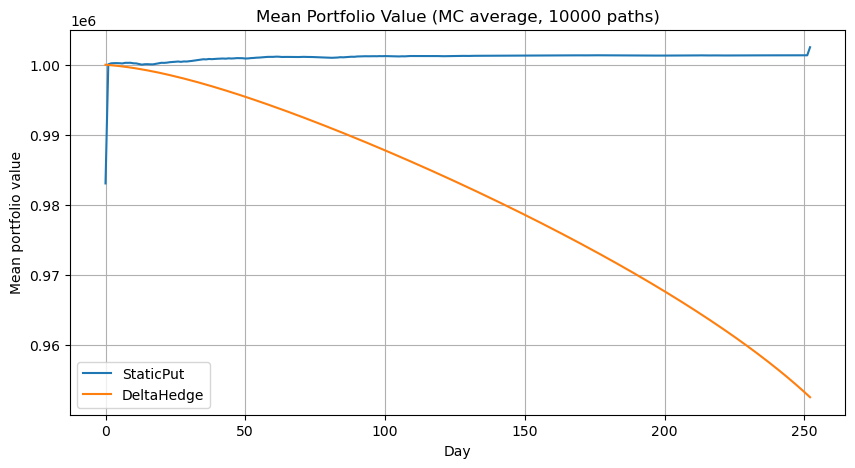

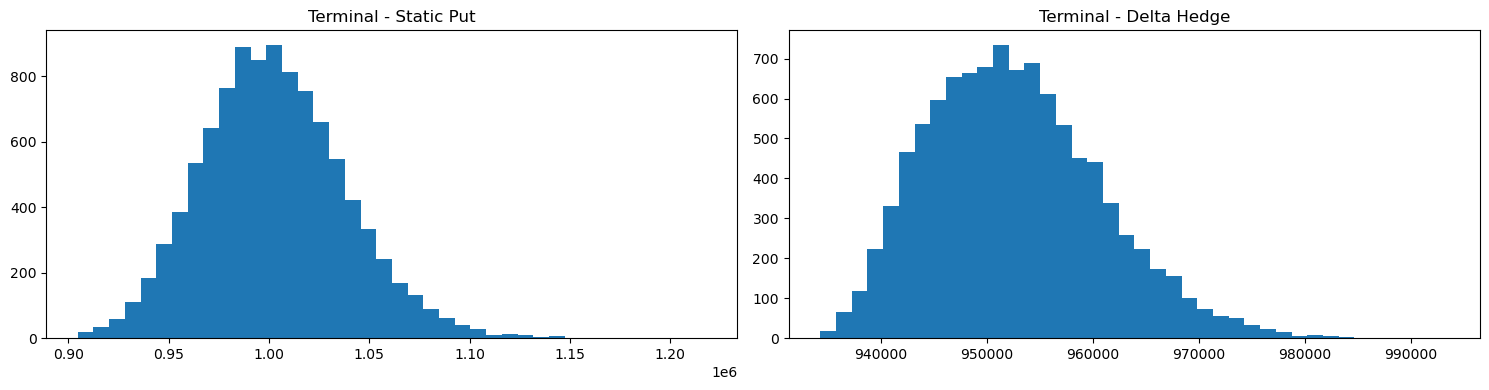

In [10]:
# Plot

days = np.arange(n_steps + 1)
plt.figure(figsize=(10, 5))

plt.plot(days, portfolio_static_put.mean(axis=0), label='StaticPut')
plt.plot(days, portfolio_delta_hedged.mean(axis=0), label='DeltaHedge')
plt.xlabel('Day')
plt.ylabel('Mean portfolio value')
plt.title(f'Mean Portfolio Value (MC average, {n_paths} paths)')
plt.legend()
plt.grid(True)

plt.savefig("new21.png")
plt.show()

# histograms of terminal distribution

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.hist(portfolio_static_put[:, -1], bins=40)
plt.title('Terminal - Static Put')

plt.subplot(1, 2, 2)
plt.hist(portfolio_delta_hedged[:, -1], bins=40)
plt.title('Terminal - Delta Hedge')
plt.tight_layout()
plt.show()

# Interpretation of Results and Plot:

The line corresponding to static put represents the stock value plus the initial put cost. The upward slope is the underlying portfolio growing due to its positive expected return. The terminal value includes the potential upside from the stock and the downside protection from the put.

The downward trend of the line corresponding to the delta hedge is the average cost of rebalancing that occurs when realized volatility (from GARCH) deviates from the implied volatility used for pricing and delta calculation.

These strategies are essential in portfolio management because they allow investors to tailor their risk-reward profile by managing volatility and drawdown risk. The core purpose of using these strategies within a Multi-Index Portfolio Simulation is to perform a quantitative risk and performance analysis.

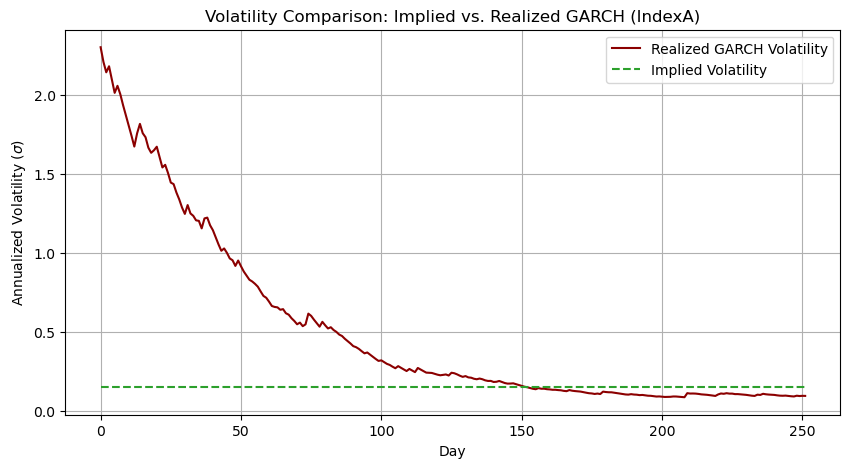

In [13]:
# Volatility Forecast Comparison (for one Index)

# We will use IndexA (sim_sigmas['IndexA'])
idx_to_plot = 'IndexA'
path_idx = 0

# Realized Volatility (GARCH sigma)
realized_sigma_path = sim_sigmas[idx_to_plot][path_idx] * np.sqrt(252.0)

# Implied Volatility (used for BS delta, assumed constant here)
# Since your original code uses a constant sigma0 (or mean sigma) for the whole period, 
# the implied vol is a flat line.
implied_vol_annual = garch_params[idx_to_plot]['sigma0']
implied_vol_path = np.full(n_steps, implied_vol_annual)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(n_steps), realized_sigma_path, label=f'Realized GARCH Volatility', color='darkred')
plt.plot(np.arange(n_steps), implied_vol_path, label='Implied Volatility', color='tab:green', linestyle='--')

plt.title(f'Volatility Comparison: Implied vs. Realized GARCH ({idx_to_plot})')
plt.xlabel('Day')
plt.ylabel('Annualized Volatility ($\sigma$)')
plt.legend()
plt.grid(True)

plt.savefig("new22.png")
plt.show()

# Interpretation

The Implied Volatility is constant, as required by the basic Black-Scholes formula used for the delta calculation.

The Realized GARCH Volatility fluctuates wildly, showing periods of high and low volatility.

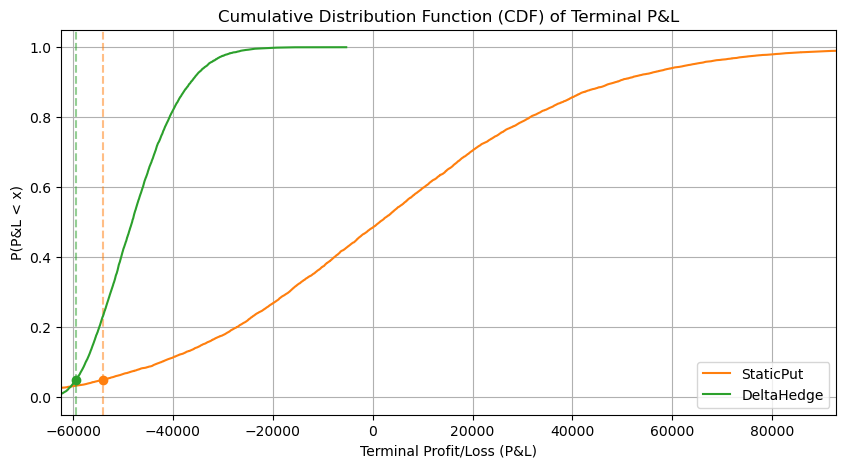

In [28]:
# 1. Cumulative Distribution Function (CDF) of Terminal P&L

# Calculate P&L for all strategies
pnl_unhedged = portfolio_unhedged[:, -1] - initial_portfolio_value
pnl_static_put = portfolio_static_put[:, -1] - initial_portfolio_value
pnl_delta_hedged = portfolio_delta_hedged[:, -1] - initial_portfolio_value

# Sort P&L values and calculate empirical CDF (probabilities)
def plot_cdf(pnl, label, color):
    pnl_sorted = np.sort(pnl)
    # The probability of having a loss less than or equal to pnl_sorted[i]
    prob = np.arange(1, len(pnl_sorted) + 1) / len(pnl_sorted)
    plt.plot(pnl_sorted, prob, label=label, color=color)
    # Highlight the 5% VaR point (95% confidence in profit distribution)
    var_95 = np.percentile(pnl_sorted, 5)
    plt.plot([var_95], [0.05], marker='o', color=color, linestyle='')
    # Add VaR line
    plt.axvline(x=var_95, color=color, linestyle='--', alpha=0.5)


plt.figure(figsize=(10, 5))

plot_cdf(pnl_static_put, 'StaticPut', 'tab:orange')
plot_cdf(pnl_delta_hedged, 'DeltaHedge', 'tab:green')

plt.title('Cumulative Distribution Function (CDF) of Terminal P&L')
plt.xlabel('Terminal Profit/Loss (P&L)')
plt.ylabel('P(P&L < x)')
plt.grid(True)
plt.legend()
plt.xlim(np.percentile(pnl_delta_hedged, 1), np.percentile(pnl_static_put, 99))

plt.savefig("new23.png")
plt.show()

# Interpretation

The Static Put line is steepest in the loss region and shift sharply to the right, illustrating how it effectively truncates the downside risk.

The Delta Hedge line confirms the increased downside risk due to the cost of hedging.